In [835]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sympy import diff, symbols, Symbol, integrate, solve, sqrt, log, sin, cos, lambdify
%matplotlib inline

# Задание 1. Линейные системы. Устойчивость численных методов.

Решить численно задачу о колебаниях в системе, где и возвращающая сила, и
коэффициент вязкого трения убывают со временем (уравнение Эйлера):
$$
\ddot{x} + 100\,\dfrac{x}{t^2} = 0
$$ 
Сначала решим численно!
Подстановка $x = t^\alpha$ дает следующее уравнение:
$$
\boxed{
    x (t) = C_1 \sqrt{t} \sin \left( \frac{1}{2} \sqrt{399} \ln{t} \right) + C_2 \sqrt{t} \cos \left( \frac{1}{2} \sqrt{399} \ln{t} \right)
}
$$

In [836]:
# Запишем решение
C1, C2, t = symbols('C1 C2 t')
sol = C1*sqrt(t)*sin(0.5*sqrt(399)*log(t)) \
                        + C2*sqrt(t)*cos(0.5*sqrt(399)*log(t))
sol_d1 = lambdify(t, diff(sol, t))
C1_sol, C2_sol = list(solve([sol_d1(1) - 1, sol.subs(t, 1) - 1]).values())
t_theor = lambdify(t, sol.subs(C1, C1_sol).subs(C2, C2_sol))

In [837]:
def compare_results(theor, predicted):
    print('  Вычисленное x(101) = ' + str(predicted))
    print('  Теоретическое x(101) = ' + str(theor))
    
def plot_lines(*args):
    for (x_data, y_data) in args:
        plt.plot(x_data, y_data)
    plt.grid()
    plt.show()

In [838]:
system_of_eq = lambda t, x: np.array([
    1.0,  # Время
    x[2],  # x точка
    -100.0*x[1]/x[0]**2,  # p точка
])

In [839]:
x_start = np.array([1.0, 1.0, 1.0])
t_stop = 101.0
t_range = np.linspace(x_start[0], t_stop, 1000)
x_range = t_theor(t_range)
h = 0.1

## Методы Эйлера

Для решения методом Эйлера разобьем на нормальную систему уравнений:

$$
\begin{cases}
    \dot{x} = p \\
    \dot{p} = -100\, \cfrac{x}{t^2}
\end{cases}
$$

### Явный метод Эйлера

In [840]:
# Явный метод Эйлера
def eiler_1(funcs, x_start, t_stop, h=0.1):
    # Начальное значение
    x = x_start
    y = [x_start.copy()]
    while x[0] < t_stop:
        x += h*funcs(x)
        y.append(x.copy())
    return y

In [841]:
# Параметр времени не используется, но мы передаем его для правильной работы scipy
x_1 = eiler_1(lambda x: system_of_eq(0, x), x_start.copy(), t_stop, h)

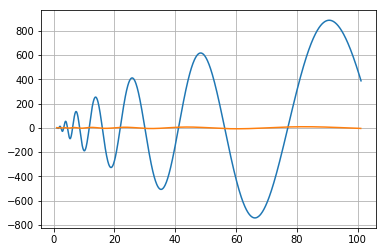

In [842]:
x_1_np = np.array(x_1).T
t_pred = x_1_np[0]
x_pred = x_1_np[1]
plot_lines((t_pred, x_pred), (t_range, x_range))

In [843]:
compare_results(t_theor(t_stop), x_1[-1][1])

  Вычисленное x(101) = 387.60543228423273
  Теоретическое x(101) = -4.73890168470781


Результаты очень плохие. Это объясняется тем, что явный метод Эйлера дает ошибку $o (h)$, которая в нашем случае оказалась велика.

### Неявный метод Эйлера

In [844]:
# Неявный метод Эйлера
def eiler_2(funcs, x_start, t_stop, h=0.1):
    # Начальное значение
    x = x_start
    y = [x_start.copy()]
    while x[0] < t_stop:
        # Прогноз
        x_tmp_tmp = x + h*funcs(x)
        # Пересчет
        x_tmp = x + h*(funcs(x) + funcs(x_tmp_tmp))/2
        x += h*(funcs(x) + funcs(x_tmp))/2
        y.append(x.copy())
    return y

In [845]:
# Параметр времени не используется, но мы передаем его для правильной работы scipy
x_2 = eiler_2(lambda x: system_of_eq(0, x), x_start.copy(), t_stop, h)

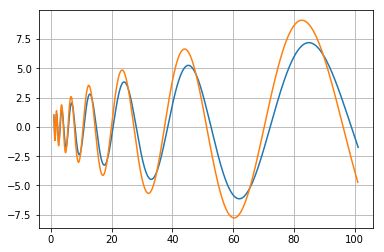

In [846]:
x_2_np = np.array(x_2).T
t_pred = x_2_np[0]
x_pred = x_2_np[1]
plot_lines((t_pred, x_pred), (t_range, x_range))

In [847]:
compare_results(t_theor(t_stop), x_2[-1][1])

  Вычисленное x(101) = -1.7472631764270963
  Теоретическое x(101) = -4.73890168470781


Неявный метод Эйлера дает неплохие результаты. Более того, он оказывается самым точным, поскольку дает точность $o(h^2)$, к тому же, имеет повышенную устройчивость и позволяет обойти некоторые проблемы при решении жестких систем ДУ.

### Метод Эйлера с центральной точкой

In [848]:
# метод Эйлера с центральной точкой
def eiler_3(funcs, x_start, t_stop, h=0.1):
    # Начальное значение
    x = x_start
    y = [x_start.copy()]
    while x[0] < t_stop:
        # Нам придется "подгядеть" f_(i+1), а затем взять полусумму с f_i
        x_tmp = (funcs(x + h*funcs(x)) + funcs(x))/2
        # Результат прибавлять в качестве вектора касательной
        x += h*x_tmp
        y.append(x.copy())
    return y

In [849]:
# Параметр времени не используется, но мы передаем его для правильной работы scipy
x_3 = eiler_3(lambda x: system_of_eq(0, x), x_start.copy(), t_stop, h)

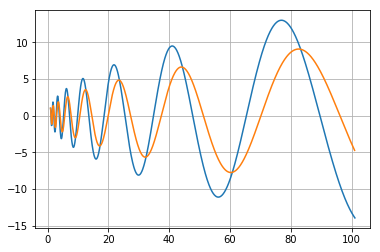

In [850]:
x_3_np = np.array(x_3).T
t_pred = x_3_np[0]
x_pred = x_3_np[1]
plot_lines((t_pred, x_pred), (t_range, x_range))

In [851]:
compare_results(t_theor(t_stop), x_3[-1][1])

  Вычисленное x(101) = -13.961618490145835
  Теоретическое x(101) = -4.73890168470781


Метод Эйлера с центральной точкой дает результаты лучше явного, но хуже неявного (из-за меньшей устойчивости по сравнению с неявным).

## Метод Дормана-Принса

In [852]:
from scipy.integrate import solve_ivp

In [853]:
x_4 = solve_ivp(system_of_eq, (x_start[0], t_stop), x_start, method='RK45', t_eval=np.arange(x_start[0], t_stop, h))

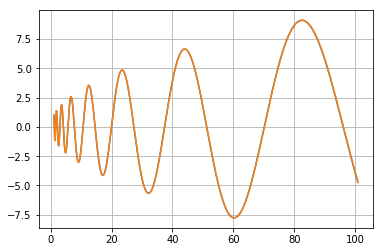

In [854]:
x_4_np = x_4.y
t_pred = x_4_np[0]
x_pred = x_4_np[1]
plot_lines((t_pred, x_pred), (t_range, x_range))

In [855]:
compare_results(t_theor(t_stop), x_4.y[1][-1])

  Вычисленное x(101) = -4.730878086598232
  Теоретическое x(101) = -4.73890168470781


Метод Дормана-Принса дает очень хорошие результаты интегрирования. Его точность составляет $o(h^4)$.

## Метод трапеций

In [856]:
# TODO: придумай, что делать с методом трапеций
def trapezium(funcs, x_start, t_stop, h=0.1):
    # Начальное значение
    x = x_start
    y = [x_start.copy()]
    while x[0] < t_stop:
        # Нам придется "подгядеть" f_(i+1), а затем взять полусумму с f_i
        x_tmp = x + h*funcs(0, x)
        # Результат прибавлять в качестве вектора касательной
        x += h*x_tmp
        y.append(x.copy())
    return y

In [857]:
x_5 = trapezium(system_of_eq, x_start, t_stop, h)

# Задание 2. Нелинейная система уравнений

Уравнение Ван-дер-Поля
$$
y'' + a (y^2 - 1) y' + y = 0 \\
y(0) = y_0 > 0; ~ y'(0) = 0, ~ 0 \leq t \leq 30, ~ a > 0 ~ (100 \div 1000)
$$

1) Проинтегрировать уравнение численно явными методами Рунге-Кутты с числом стадий 2, 3 и 4 с процедурой автоматического выбора шага.

Для этого представим уравнение в виде системы:
$$
\begin{cases}
    y' = -p \\
    p' = ap (y^2 - 1) + y
\end{cases}
$$

In [858]:
# Пробуем через sympy делать все в общем виде
a, y0 = symbols('a y_0')
a = 5
system_of_eq = lambda x, y: [
    -y[0], 
    a*y[1]*(y[0]**2 - 1) + y[0]
]

In [859]:
y0 = 2
y_0 = [y0, 0]
t_min, t_max = 0, 30

t_range = np.linspace(t_min, t_max, 1000)

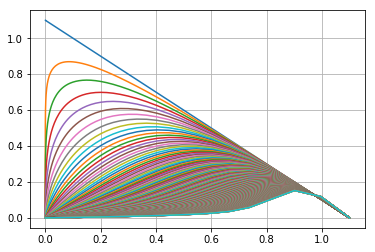

In [860]:
data = []
# В общем виде не получается. Посмотрим на конкретных значениях параметра `a`
for a in np.arange(0, 40, 0.1):
    system_of_eq = lambda x, y: [
        -y[0], 
        a*y[1]*(y[0]**2 - 1) + y[0]
    ]
    y_0 = [1.1, 0]
    sol = solve_ivp(system_of_eq, (t_min, t_max), y_0, t_eval=np.arange(t_min, t_max, 0.1)).y
    data.append((sol[0], sol[1]))
plot_lines(*data)

In [973]:
# Явный метод Рунге-Кутты. Принимает на фход матрицу Бутчера. В примере - классический Рунге (4-й порядок). Интерфейс как у всех
class RungeExplicit:
    def __init__(self, butcher):
        self.alphas = butcher[:-1, 0]
        self.order = len(self.alphas)
        self.gammas = butcher[-1, 1:]
        self.betas = butcher[:-1, 1:]
    def __call__(self, funcs, x_start, t_stop, h=0.1):
        x = np.array(x_start)
        y = [x_start.copy()]
        while x[0] < t_stop:
            K = []
            for i in range(self.order):
                addition = np.zeros(len(x))
                addition[0] = self.alphas[i]*h
                for j in range(len(K)):
                    addition[1:] += h*K[j]*self.betas[i, j]
                K.append(funcs(x+addition)[1:])
            for i in range(len(K)):
                x += np.array([0] + list(h*K[i]*self.gammas[i]))
            x += np.array([h] + [0]*(len(x)-1))
            y.append(x.copy())
        return y

In [974]:
system_of_eq = lambda t, x: np.array([
    1.0,  # Время
    x[2],  # x точка
    -100.0*x[1]/x[0]**2,  # p точка
])

In [975]:
x_start = np.array([1.0, 1.0, 1.0])
t_stop = 101.0
t_range = np.linspace(x_start[0], t_stop, 1000)
x_range = t_theor(t_range)
h = 0.1

In [976]:
# 3-й порядок
# method = RungeExplicit(np.array([[0,0,0,0], [0.5, 0.5, 0, 0], [1, 0, 1, 0], [0, 1/6, 2/3, 1/6]]))
# 2-й порядок
# method = RungeExplicit(np.array([[0,0,0],[0.5,0.5,0.5],[0,0,1]]))
# Классический
method = RungeExplicit(np.array([[0,0,0,0,0],[0.5,0.5,0,0,0],[0.5,0,0.5,0,0],[1,0,0,1,0],[0,1/8,3/8,3/8,1/8]]))

In [977]:
method.alphas, method.betas, method.gammas

(array([0. , 0.5, 0.5, 1. ]), array([[0. , 0. , 0. , 0. ],
        [0.5, 0. , 0. , 0. ],
        [0. , 0.5, 0. , 0. ],
        [0. , 0. , 1. , 0. ]]), array([0.125, 0.375, 0.375, 0.125]))

In [978]:
method.order

4

In [979]:
x_1 = method(lambda x: system_of_eq(0, x), x_start.copy(), t_stop, h)

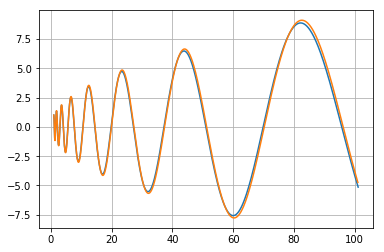

In [980]:
x_1_np = np.array(x_1).T
t_pred = x_1_np[0]
x_pred = x_1_np[1]
plot_lines((t_pred, x_pred), (t_range, x_range))